In [24]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.distributions as D

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

sns.set_theme(style="dark")

In [25]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    # if torch.backends.mps.is_available():
        # return torch.device("mps")
    return torch.device("cpu")

DEVICE = get_default_device()

In [26]:
class Flow(nn.Module):
    def __init__(self, latent_dim=512):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2 + 1, latent_dim),
            nn.ELU(),
            nn.Linear(latent_dim, latent_dim),
            nn.ELU(),
            nn.Linear(latent_dim, latent_dim),
            # nn.ELU(),
            # nn.Linear(latent_dim, latent_dim),
            nn.ELU(),
            nn.Linear(latent_dim, 2),
        )

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        if x.ndim != t.ndim:
            fill_value = t.item() if isinstance(t, torch.Tensor) else t
            t_tensor = torch.full((x.shape[0], 1), fill_value, device=x.device, dtype=x.dtype)
        else:
            t_tensor = t
        emb_x = torch.cat([x, t_tensor], dim=1)
        return self.net(emb_x)

    def ode_forward(self, t, x):
        return self.forward(x, t)


In [27]:
from typing import Callable


class BlobsDataset(Dataset):
    def __init__(
        self,
        initial_dist: Callable[[tuple[int, ...]], torch.Tensor],
        target_dist: Callable[[tuple[int, ...]], torch.Tensor],
        num_samples: int = 1024,
        device: torch.device | None = None,
        t_dist: Callable[[int], torch.Tensor] | None = None,
    ):
        self.device = device
        self.p = initial_dist
        self.X = target_dist((num_samples,))
        self.sample_t = t_dist or (lambda: torch.rand(1))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        p0 = self.p((1,))[0]
        p1 = self.X[idx]
        if self.device:
            return p0.to(self.device), p1.to(self.device)
        return p0, p1

In [28]:
def time_distribution(batch_size):
    return torch.rand(batch_size, 1)

In [29]:
def create_gmm_sampler(
    means: list[tuple[float, float]], stds: list[float] | list[tuple[float, float]]
) -> Callable[[tuple[int, ...]], torch.Tensor]:
    means_t = torch.tensor(means)
    stds_t = torch.tensor(stds)
    if len(stds_t.shape) == 1:
        stds_t = stds_t.unsqueeze(1).expand_as(means_t)
    else:
        assert stds_t.shape == means_t.shape

    num_components = len(means)

    mix = D.Categorical(torch.ones(num_components))
    components = D.Independent(D.Normal(loc=means_t, scale=stds_t), 1)
    gmm = D.MixtureSameFamily(mix, components)

    return gmm.sample


def create_uniform_sampler(
    low: list[float] | tuple[float, float], high: list[float] | tuple[float, float]
) -> Callable[[tuple[int, ...]], torch.Tensor]:
    low_t = torch.tensor(low)
    high_t = torch.tensor(high)
    assert low_t.shape == high_t.shape
    return D.Uniform(low_t, high_t).sample


p0_mu = [(0., 0.)]
p0_std = [(0.4, 1.)]

p1_mu = [(-3., 0.), (3., -1.)]
p1_std = [(0.4, 0.7), (0.4, 0.4)]

# sample_p1 = create_gmm_sampler(means=p0_mu, stds=p1_std)
sample_p0 = create_uniform_sampler(low=[-5., -5.], high=[5., 5.])
sample_p1 = create_gmm_sampler(means=p1_mu, stds=p1_std)

In [30]:
data = BlobsDataset(
    num_samples=1024,
    initial_dist=sample_p0,
    target_dist=sample_p1,
    device=DEVICE,
    t_dist=time_distribution,
)
dataloader = DataLoader(data, batch_size=128, shuffle=True)

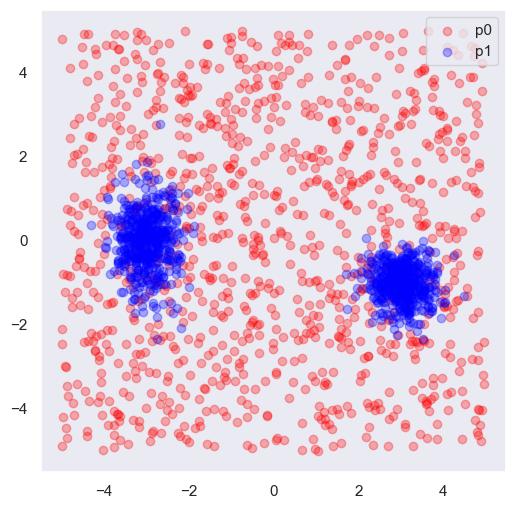

In [31]:
p0s = []
p1s = []
for batch in dataloader:
    p0s.append(batch[0])
    p1s.append(batch[1])
p0s = torch.cat(p0s, dim=0).cpu().numpy()
p1s = torch.cat(p1s, dim=0).cpu().numpy()

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(p0s[:, 0], p0s[:, 1], c="red", label="p0", alpha=0.3)
ax.scatter(p1s[:, 0], p1s[:, 1], c="blue", label="p1", alpha=0.3)
ax.legend()
plt.show()

In [32]:
N_EPOCHS = 200

model = Flow().to(DEVICE)
optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=N_EPOCHS)

In [33]:
def train(
    model: nn.Module,
    dataloader: DataLoader,
    n_epochs: int,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler.CosineAnnealingLR,
    t_dist: Callable[[int], torch.Tensor] | None = None,
    verbose: bool = False,
    contrastive_flow_weight: float = 0.05,
):
    log_interval = n_epochs // 10
    t_dist = t_dist or (lambda batch_size: torch.rand(batch_size, 1))
    model.train()
    loss_history = []
    for epoch in range(n_epochs):
        losses = []
        for p0, p1 in dataloader:
            p0, p1 = p0.to(DEVICE), p1.to(DEVICE)
            bsz, _ = p0.shape
            t = t_dist(bsz).to(DEVICE)
            z = t * p1 + (1 - t) * p0
            target_u = p1 - p0
            u = model(z, t)
            loss = F.mse_loss(u, target_u)
            if contrastive_flow_weight > 0.0:
                u_hat = torch.roll(u, shifts=1, dims=0)
                loss_contrastive = F.mse_loss(u, u_hat)
                loss = loss - contrastive_flow_weight * loss_contrastive
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        scheduler.step()
        if epoch % log_interval == 0 or epoch == n_epochs - 1:
            if verbose:
                print(f"Epoch {epoch} loss: {np.mean(losses):.4f}")
        loss_history.append(np.mean(losses))
    return loss_history

Epoch 0 loss: 12.5755
Epoch 20 loss: 8.1493
Epoch 40 loss: 6.8045
Epoch 60 loss: 6.3089
Epoch 80 loss: 6.6686
Epoch 100 loss: 6.4088
Epoch 120 loss: 6.7708
Epoch 140 loss: 6.4218
Epoch 160 loss: 6.6109
Epoch 180 loss: 6.1146
Epoch 199 loss: 6.1874


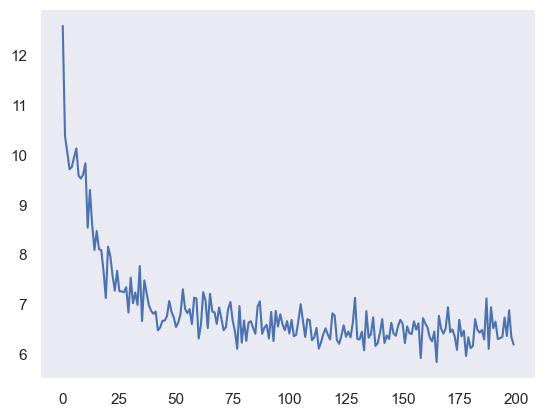

In [34]:
loss_history = train(
    model=model,
    dataloader=dataloader,
    n_epochs=N_EPOCHS,
    optimizer=optimizer,
    scheduler=scheduler,
    t_dist=time_distribution,
    verbose=True,
)
plt.plot(loss_history)
plt.show()


In [35]:
from sklearn.mixture import GaussianMixture
from torchdiffeq import odeint
from matplotlib.collections import LineCollection
from typing import cast
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128


@torch.no_grad()
def sample_with_ode(
    model: nn.Module,
    initial_dist: Callable[[tuple[int, ...]], torch.Tensor],
    n_samples: int = 500,
    n_steps: int = 100,
):
    model.eval()
    model_device = next(model.parameters()).device
    initial_samples = torch.randn(n_samples, 2).to(model_device)
    initial_samples = initial_dist((n_samples,)).to(model_device)
    t_span = torch.linspace(0.0, 1.0, n_steps).to(model_device)
    trajectory = odeint(
        model.ode_forward,
        initial_samples,
        t_span,
        method="euler",
        atol=1e-5,
        rtol=1e-5,
    )
    trajectory = cast(torch.Tensor, trajectory)

    return trajectory.cpu().numpy()


def general_plot(
    model,
    title: str = "",
    n_samples: int = 500,
    n_steps: int = 20,
    animate: bool = False,
):
    samples = sample_with_ode(
        model, initial_dist=sample_p0, n_samples=n_samples, n_steps=n_steps
    )
    device = samples.device if isinstance(samples, torch.Tensor) else 'cpu'
    if isinstance(samples, torch.Tensor):
        samples = samples.cpu().numpy()


    target_data_np = data.X.cpu().numpy()
    gmm = GaussianMixture(n_components=len(p1_mu), random_state=42)
    gmm.fit(target_data_np)

    x_min, x_max = -4, 4
    y_min, y_max = -4, 4
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid_points_gmm = np.c_[xx.ravel(), yy.ravel()]
    log_probs = gmm.score_samples(grid_points_gmm)
    Z = np.exp(log_probs).reshape(xx.shape)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect("equal")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title(f"{title} | {n_steps} steps")

    ax.contourf(xx, yy, Z, levels=20, cmap="Blues", alpha=1.0)
    ax.contour(xx, yy, Z, levels=10, colors="black", linewidths=0.5, alpha=0.4)

    if animate:
        time_steps = np.linspace(0, 1, n_steps)

        quiver_xx, quiver_yy = np.meshgrid(np.linspace(x_min, x_max, 20), np.linspace(y_min, y_max, 20))
        quiver_grid = np.c_[quiver_xx.ravel(), quiver_yy.ravel()]
        quiver_grid_torch = torch.tensor(quiver_grid, dtype=torch.float32).to(device)

        scatter = ax.scatter(samples[0, :, 0], samples[0, :, 1], c="blue", alpha=0.5)

        with torch.no_grad():
            initial_velocities = model(quiver_grid_torch, time_steps[0]).cpu().numpy()
        U_initial, V_initial = initial_velocities[:, 0], initial_velocities[:, 1]
        quiver = ax.quiver(
            quiver_xx, quiver_yy, U_initial, V_initial, color="black", alpha=0.6
        )

        ax.set_title(f"{title} | Step 0/{n_steps}")

        def update(frame):
            scatter.set_offsets(samples[frame])

            t = time_steps[frame]
            with torch.no_grad():
                velocities = model(quiver_grid_torch, t).cpu().numpy()
            U, V = velocities[:, 0], velocities[:, 1]
            quiver.set_UVC(U, V)

            ax.set_title(f"{title} | Step {frame}/{n_steps}")
            return (scatter, quiver)

        anim = FuncAnimation(fig, update, frames=n_steps, interval=100, blit=False)
        plt.close(fig)
        return HTML(anim.to_jshtml())

    else:
        final_samples = samples[-1]
        initial_samples = samples[0]

        trajectory_per_sample = np.transpose(samples, (1, 0, 2))
        segments = [path for path in trajectory_per_sample]
        lines = LineCollection(segments, colors="green", linewidths=0.5, alpha=0.2)
        ax.add_collection(lines)

        ax.scatter(initial_samples[:, 0], initial_samples[:, 1], c="red", label="initial", alpha=0.5)
        ax.scatter(
            final_samples[:, 0],
            final_samples[:, 1],
            c="blue",
            label="final",
            alpha=0.5,
            edgecolors="black",
        )
        ax.legend()
        plt.show()

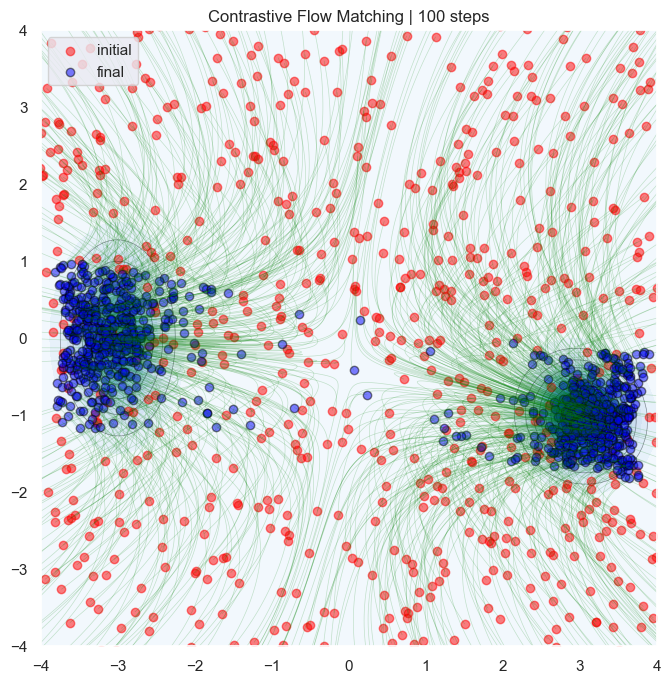

In [36]:
general_plot(model.to("cpu"), title="Contrastive Flow Matching", n_samples=1000, n_steps=100)

In [ ]:
general_plot(model.to("cpu"), title="Contrastive Flow Matching", n_samples=1000, n_steps=100, animate=True)

In [38]:
from torch.utils.data import TensorDataset


@torch.no_grad()
def generate_rectified_dataset(
    model_v0: nn.Module, original_dataset: torch.Tensor, n_steps=100, batch_size=512
):
    model_v0.eval()
    model_device = next(model_v0.parameters()).device
    t_span = torch.linspace(1.0, 0.0, n_steps).to(model_device)
    p1_data = original_dataset.to(model_device)

    p0_rectified_list = []
    for p1_batch in torch.split(p1_data, batch_size):
        p0_batch = odeint(
            model_v0.ode_forward,
            p1_batch,
            t_span,
            method="euler",
            atol=1e-5,
            rtol=1e-5,
        )[-1]
        p0_rectified_list.append(p0_batch)

    p0_rectified = torch.cat(p0_rectified_list, dim=0)
    return TensorDataset(p0_rectified.cpu(), original_dataset.cpu())


In [39]:
N_EPOCHS_RF = 100
rf_model = Flow().to(DEVICE)
rectified_dataset = generate_rectified_dataset(model_v0=model.to("cpu"), original_dataset=data.X)
dataloader = DataLoader(rectified_dataset, batch_size=128, shuffle=True)
optimizer = AdamW(rf_model.parameters(), lr=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=N_EPOCHS_RF)

In [40]:
loss_history = train(
    rf_model,
    dataloader,
    n_epochs=N_EPOCHS_RF,
    optimizer=optimizer,
    scheduler=scheduler,
    t_dist=time_distribution,
)

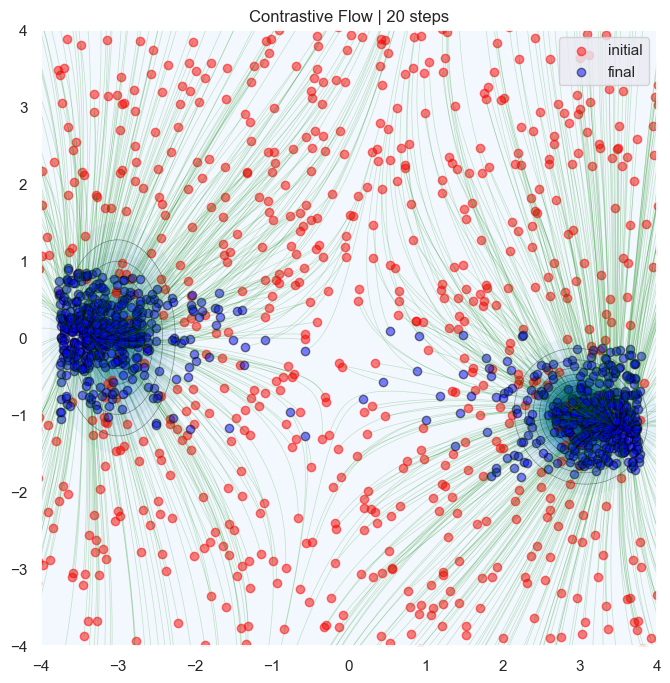

In [41]:
general_plot(rf_model, title="Contrastive Flow", n_samples=1000, n_steps=20)

In [ ]:
general_plot(rf_model, title="Contrastive Flow", n_samples=1000, n_steps=20, animate=True)

In [43]:
rf_model_2 = Flow().to(DEVICE)
rectified_dataset = generate_rectified_dataset(
    model_v0=rf_model, original_dataset=data.X
)
dataloader = DataLoader(rectified_dataset, batch_size=128, shuffle=True)
optimizer = AdamW(rf_model_2.parameters(), lr=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=N_EPOCHS_RF)

In [44]:
loss_history = train(
    rf_model_2,
    dataloader,
    n_epochs=N_EPOCHS_RF,
    optimizer=optimizer,
    scheduler=scheduler,
    t_dist=time_distribution,
)

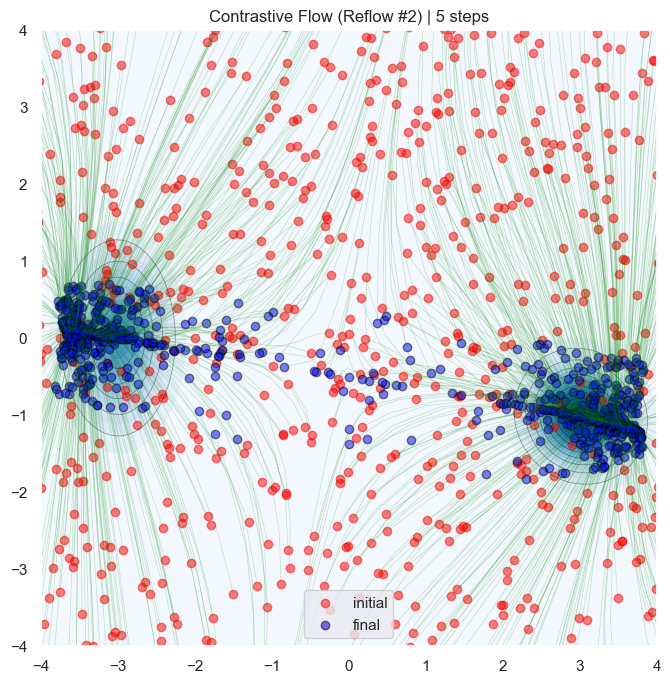

In [45]:
general_plot(rf_model_2, title="Contrastive Flow (Reflow #2)", n_samples=1000, n_steps=5)

In [ ]:
general_plot(rf_model_2, title="Contrastive Flow (Reflow #2)", n_samples=1000, n_steps=5, animate=True)